# Pop Music Through the Ages: A CNN Model of Spectrograms

The objective of this project is to build a model that classifies songs from the Billboard Top 100 by decade.  To achieve this, I have used a convolutional neural network trained on spectograms obtained from 5 second clips from the middle of each song.  A spectrogram is a visual representation of the spectrum of sound frequencies.  By creating a "picture" of the sound, we are now able to take advantage of the power of convolutional neural networks, a method used in image classification. This model achieves an accuracy of 48% for identifying the correct decade and an accuracy of 85% for identifying plus or minus one decade.

From this model, I've made some pretty cool insights about pop music through the ages.  Here are a few highlights:

* 1960s music was easiest to classify correctly, suggesting it may be the most distinctive music era.  
* One song that may be ahead of it's time is:
    "A Hard Day's Night" by the Beatles (from the 1960s and classified as the 1980s)
* Some songs that were easiest to classify, suggesting they exemplify their era are:
    "It's Too Late" by Carole King (from the 1970s),
    "Jack and Diane" by John Mellencamp (from the 1980s) 
* One song that feels "retro" is:
    "So Hard To Say Goodbye" by Boyz 2 Men (from the 1990s and classified as the 1960s)


## Implementation

For this project, I used librosa for audio processing and keras for the convolutional neural networks.

In [1]:
%matplotlib inline
import librosa
from librosa.display import specshow
import os
import glob
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GroupKFold
from sklearn.metrics import confusion_matrix
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, Convolution2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import ELU
from keras.utils import np_utils
from keras import backend as K
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint
from matplotlib import cm
import matplotlib.pyplot as plt
import seaborn
import IPython.display as ipd
import h5py as h5py

Using TensorFlow backend.


The dataset I used is a collection of the mp3 files of all of the Billboard Top 100 Lists from 1955 to 1916.

In [2]:
music_files = sorted(glob.glob('/Users/edatta/Desktop/MUSICZ/*/*.mp3'))

Spectrograms are visual representations of songs that show the spectrum of sound frequency.  Here, we calculate the log of the mel-scaled spectrograms from each audio file.

In [3]:
if os.path.exists('LogSpectograms.npy'):
    X = np.load('LogSpectograms.npy')

else:
    X = []
    for i,music_file in enumerate(music_files):
        if '/1_' in music_file:
            print(os.path.basename(os.path.dirname(music_file)))
        audio_time_series, sampling_rate = librosa.load(music_file)
    
        # Get middle 5 seconds of song
        length = len(audio_time_series)
        middle_index = int(length/2)
        song_middle = audio_time_series[middle_index-50000:middle_index+50000]
    
        # Calculate log spectrogram
        spectrogram = librosa.feature.melspectrogram(song_middle, sampling_rate)
        log_spectrogram = librosa.logamplitude(spectrogram)
        X.append(log_spectrogram)
    np.save('LogSpectograms.npy', np.asarray(X))

We can visualize these log mel-scaled spectrograms to get an idea of how they may differ according to song.  Below, we see a comparison of the log spectrogram image from clips from two very different songs, "The Twist" (the number one song from 1962) and "In Da Club" (the number one song from 2003). 

1962
The Twist
Chubby Checker


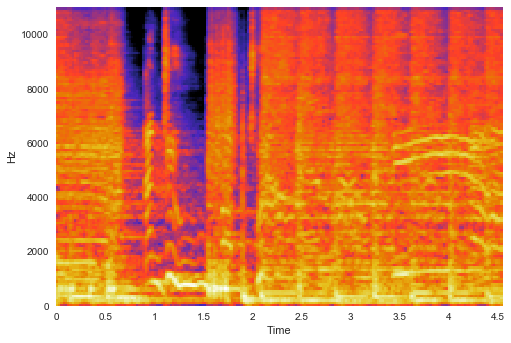

2003
In Da Club
50 Cent


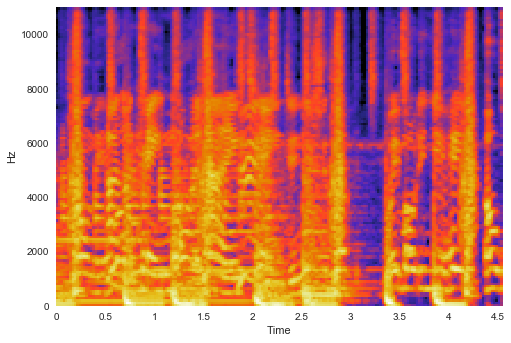

In [4]:
song_indices = [3284,7384]

for i,index in enumerate(song_indices):
    filename = music_files[index]
    parts = filename.split('_')
    song = parts[1]
    artist = parts[2].split('.')[0]
    yr = os.path.basename(os.path.dirname(filename))
    
    logS = X[index,:,:]
    specshow(logS, cmap='CMRmap', x_axis='time', y_axis='linear')
    
    audio_time_series, sampling_rate = librosa.load(filename)
    length = len(audio_time_series)
    middle_index = int(length/2)
    song_middle = audio_time_series[middle_index-50000:middle_index+50000]
    
    print(yr)
    print(song)
    print(artist)
    ipd.display(ipd.Audio(song_middle, rate=sampling_rate))
    plt.show()

For use in the convolutional neural network, it is necessary to normalize the input array and reshape the array.

In [5]:
# Normalize log spectrograms and save as floats
X = np.asarray(X)
max_value = np.amax(X)
X = X.astype('float32')
X = X/max_value
np.save('Spectograms.npy', X)

# Reshape X for use with TensorFlow backend
img_rows = X.shape[1]
img_cols = X.shape[2]
if K.image_data_format() == 'channels_first':
    shape = (1, img_rows, img_cols)
else:  # channel_last
    shape = (img_rows, img_cols, 1)
X = X.reshape((X.shape[0],) + shape)

For the outputs, I obtain the decade for each of the music files.  For use in the convolutional neural network, I've encoded the outputs in a one hot array.  The function "get_Y_decade" is defined so that it is easy to convert easily from the one hot array back to the decade or chart position.  

In [6]:
if os.path.exists('Y_decade.npy'):
    Y = np.load('Y_decade.npy')
else:
    Y = []
    for i,music_file in enumerate(music_files):
        decade = (int(os.path.basename(os.path.dirname(music_file)))-1900)/10
        Y.append(decade)
    Y = np.asarray(Y)
    unique_values = np.unique(Y)
    Y = np_utils.to_categorical(Y,len(unique_values))
    Y = Y.astype(int)
    np.save('Y_decade.npy', Y_decade)  
    
def get_Y_decade(Y):
    Y_decade = np.argmax(Y,axis=1)
    Y_decade = (Y_decade*10)+1950
    return Y_decade

My data set includes music from 1900 to present day, but since the lists from earlier years are shorter and the music clips from earlier years are of worse quality, I will extract only the music files from the Billboard Top 100 charts (1955-present) and split into training, validation, and test sets.

In [7]:
# Only use music files from the Billboard Top 100 charts (1955-present) 
music_files = music_files[2643:]
X = X[2643:,:,:,:] 
Y = Y[2643:,5:] 
np.save('Billboard_LogSpectograms.npy', np.asarray(X))

#X_train, X_test, Y_train, Y_test, music_files_train, music_files_test = train_test_split(X,Y,music_files,test_size=.33)
# Use the top 10 songs from each year as the test set (10% of the available data)
music_files_train = []
X_train = []
Y_train = []
music_files_test = []
X_test = []
Y_test = []

for i, music_file in enumerate(music_files):
    song_num = int(os.path.basename(music_file).split('_')[0])
    if song_num > 10:
        music_files_train.append(music_file)
        X_train.append(X[i,:,:,:])
        Y_train.append(Y[i,:])
    else:
        music_files_test.append(music_file)
        X_test.append(X[i,:,:,:])
        Y_test.append(Y[i,:])

X_train = np.asarray(X_train)
Y_train = np.asarray(Y_train)
X_test = np.asarray(X_test)
Y_test = np.asarray(Y_test)
# From the remaining data, split randomly into a training set and validation set (81% and 9% of data respectively)
X_train, X_valid, Y_train, Y_valid, music_files_train, music_files_valid = train_test_split(X_train,Y_train,music_files_train,test_size=.1)


Delete any songs from training set that also appear in the test set

In [8]:
music_files_test_songs = [os.path.basename(filename).split('_')[1]+'_'+os.path.basename(filename).split('_')[2] for filename in music_files_test]
music_files_train_songs = [os.path.basename(filename).split('_')[1]+'_'+os.path.basename(filename).split('_')[2] for filename in music_files_train]
music_files_train_new = music_files_train

for i, song in enumerate(music_files_train_songs):
    if song in music_files_test_songs:
        del music_files_train_new[i]
        X_train = np.delete(X_train, (i), axis=0)
        Y_train = np.delete(Y_train, (i), axis=0)

music_files_train = music_files_train_new

Define the architecture of the convolutional neural network and train the model using cross validation.  The diagram below shows a similar architecture to the one I am using.  The model here has two convolutional layers, followed by a pooling layer.  The input is then flattened and there are two dense fully connected layers.  The output is obtained by using softmax to convert the probabilities into classes.  A rectifier (ReLu) function is used for activation.  Dropout layers randomly set certain input units to 0, which help prevent overfitting.
<img src="https://www.mathworks.com/content/mathworks/www/en/discovery/convolutional-neural-network/jcr:content/mainParsys/image_copy.adapt.full.high.jpg/1506591535706.jpg">
(Diagram from https://www.mathworks.com/discovery/convolutional-neural-network.html)

In [9]:
nb_classes = Y_train.shape[1]
shape = (X_train.shape[1],X_train.shape[2],1)
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes, activation='softmax'))

sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

Now, train the model with cross validation.

In [10]:
weights_file = 'best_weights.hdf5'
if(os.path.exists(weights_file)):
    model.load_weights(weights_file)
else:
    checkpt = ModelCheckpoint(weights_file, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    early = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto')
    callbacks = [checkpt, early]
    hist = model.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), batch_size=32, nb_epoch=20, verbose=1, shuffle=True, callbacks=callbacks)                        

Calculate the predicted decades and the probabilities used for prediction.  Also, calculate the accuracy of the model when evaluated on the test data.  48% of the songs were classified correctly and 85% of the songs were classified correctly within one decade.

In [11]:
model.load_weights(weights_file)
score = model.evaluate(X_test, Y_test, verbose=1)
Y_predict = model.predict(X_test)
Y_predict_proba = model.predict_proba(X_test)

Y_test_decade = get_Y_decade(Y_test)
Y_predict_decade = get_Y_decade(Y_predict)

acc = score[1]
deltas = np.abs(Y_test_decade - Y_predict_decade)
deltas_within_10 = deltas[deltas<=10]
acc_within_10 = len(deltas_within_10)/float(len(deltas))
print('ACCURACY:')
print(acc)
print('ACUURACY WITHIN ONE DECADE')
print(acc_within_10)

620/620 [==============================] - 14s    
ACCURACY:
0.483870967838
ACUURACY WITHIN ONE DECADE
0.854838709677


The confusion matrix below shows how the convolutional neural network performs and where most of the errors occur.  From this confusion matrix, we can see that most misclassifications were made plus or minus one decade, which makes sense since music styles don't change magically at the decade mark.

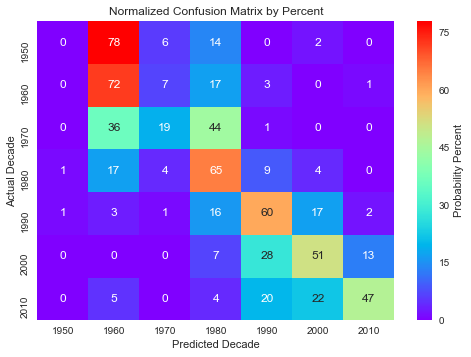

In [12]:
confusion = confusion_matrix(Y_test_decade, Y_predict_decade)
decades = np.unique(Y_test_decade).tolist()
confusion_df = pd.DataFrame(confusion, index=decades, columns=decades)

normalized_confusion = confusion.astype('float') / confusion.sum(axis=1)[:, np.newaxis]
normalized_confusion = (normalized_confusion*100).astype(int)
normalized_confusion_df = pd.DataFrame(normalized_confusion, index=decades, columns=decades)
confusion_plt = seaborn.heatmap(normalized_confusion_df,cmap=cm.rainbow,cbar_kws={'label': 'Probability Percent'}, annot=True, fmt="d")
confusion_plt.set(xlabel='Predicted Decade', ylabel='Actual Decade')
confusion_plt.set_title('Normalized Confusion Matrix by Percent')
confusion_plt_fig = confusion_plt.get_figure()
confusion_plt_fig.savefig('Plot1_Confusion_Matrix.png')
plt.show()

### Let's now look at how the model performs on the whole data set to make some insights about songs!  

First, I'll print a table of the song that had the highest probability for each square in the confusion matrix.  The columns are the actual decades and the rows are the predicted decades.  The songs along the diagonal were the easiest to classify correctly and the other songs are the most egregious mistakes for that classification error.

In [13]:
music_files_test = np.asarray(music_files_test)
decades = np.unique(Y_test_decade).tolist()
target_df_list = []

for i, target in enumerate(decades):
    songnames = []
    artists = []
    probabilities = []
    
    for decade in decades:
        songs_from_decade = music_files_test[Y_test_decade == decade]
        predictions_for_songs_from_decade = Y_predict_decade[Y_test_decade == decade]
        probabilities_for_songs_from_decade = (np.asarray(Y_predict_proba))[Y_test_decade == decade,:]
        
        songs_classified_as_target = songs_from_decade[np.argwhere(predictions_for_songs_from_decade == target)]
        probabilities_for_songs_classified_as_target = np.squeeze(probabilities_for_songs_from_decade[np.argwhere(predictions_for_songs_from_decade == target)],axis=1)[:,i]
        
        if songs_classified_as_target.tolist():
            highest_probability_index = np.argmax(probabilities_for_songs_classified_as_target)
            highest_probability = probabilities_for_songs_classified_as_target[highest_probability_index]
            most_probable_song = songs_classified_as_target[highest_probability_index]
            
            songnames.append(os.path.basename(most_probable_song[0]).split('_')[1])
            artists.append(os.path.basename(most_probable_song[0]).split('_')[2].split('.')[0])
            probabilities.append(highest_probability)
        else:
            songnames.append('')
            artists.append('')
            probabilities.append(0)
        
    target_df = pd.DataFrame(index=decades,columns=['Song','Artist','Probability'])
    target_df['Song'] = songnames
    target_df['Artist'] = artists
    target_df['Probability'] = probabilities
    target_df_list.append(target_df)
confusion_df = pd.concat(target_df_list, keys=decades, axis=1)    
    
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', -1):
    ipd.display(confusion_df)

1950                            \
                        Song        Artist Probability   
1950                                        0.000000     
1960                                        0.000000     
1970                                        0.000000     
1980  Rose, The               Bette Midler  0.407873     
1990  So Hard To Say Goodbye  Boyz II Men   0.310974     
2000                                        0.000000     
2010                                        0.000000     

                             1960                                \
                             Song            Artist Probability   
1950  Les Baxter                   Unchained Melody  0.784102     
1960  Theme From A Summer Place    Percy Faith       0.838241     
1970  Take Me Home, Country Roads  John Denver       0.762316     
1980  Coming Up                    Paul McCartney    0.715544     
1990  Goodbye England's Rose       Elton John        0.502082     
2000                                                 0.000000     
2010  Me, Myself & I               G-Eazy            0.631581     

                               1970                                 \
                               Song                         Artist   
1950  Don't Forbid Me                Pat Boone                       
1960  I'll Never Fall In Love Again  Tom Jones                       
1970  It's Too Late                  Carole King                     
1980  Sweet Child O' Mine            Guns N' Roses                   
1990  Heartbreak Hotel               Whitney Houston & Faith Evans   
2000                                                                 
2010                                                                 

                                  1980                                \
     Probability                  Song            Artist Probability   
1950  0.387920    Patricia              Perez Prado       0.546988     
1960  0.455391    A Hard Days Night     Beatles           0.716400     
1970  0.569419    Boogie Oogie Oogie    A Taste Of Honey  0.864569     
1980  0.533250    Jack & Diane          John Mellencamp   0.839259     
1990  0.246905    Nothing Compares 2 U  Sinead O'Connor   0.785817     
2000  0.000000    You're Beautiful      James Blunt       0.622009     
2010  0.000000    The Monster           Eminem            0.543414     

                      1990                                      \
                      Song                  Artist Probability   
1950                                                0.000000     
1960  Good Lovin'           The Young Rascals       0.443866     
1970  My Love               Paul McCartney & Wings  0.379744     
1980  Blame It On The Rain  Milli Vanilli           0.789427     
1990  Return Of The Mack    Mark Morrison           0.825690     
2000  Check On It           Beyonce Ft Slim Thug    0.699316     
2010  Counting Stars        OneRepublic             0.663288     

                           2000                                \
                           Song            Artist Probability   
1950  All I Have To Do Is Dream  Everly Brothers   0.367460     
1960                                               0.000000     
1970                                               0.000000     
1980  Wind Beneath My Wings      Bette Midler      0.493008     
1990  Baby Got Back              Sir Mix A Lot     0.634716     
2000  No One                     Alicia Keys       0.793687     
2010  Call Me Maybe              Carly Rae Jepsen  0.675741     

                         2010                                       
                         Song                   Artist Probability  
1950                                                    0.000000    
1960  I Can't Stop Loving You  Ray Charles              0.243893    
1970                                                    0.000000    
1980                                                    0.000000    
1990  Jump            

The plot below shows how the probabilities were distributed for each of the songs in the chart above.

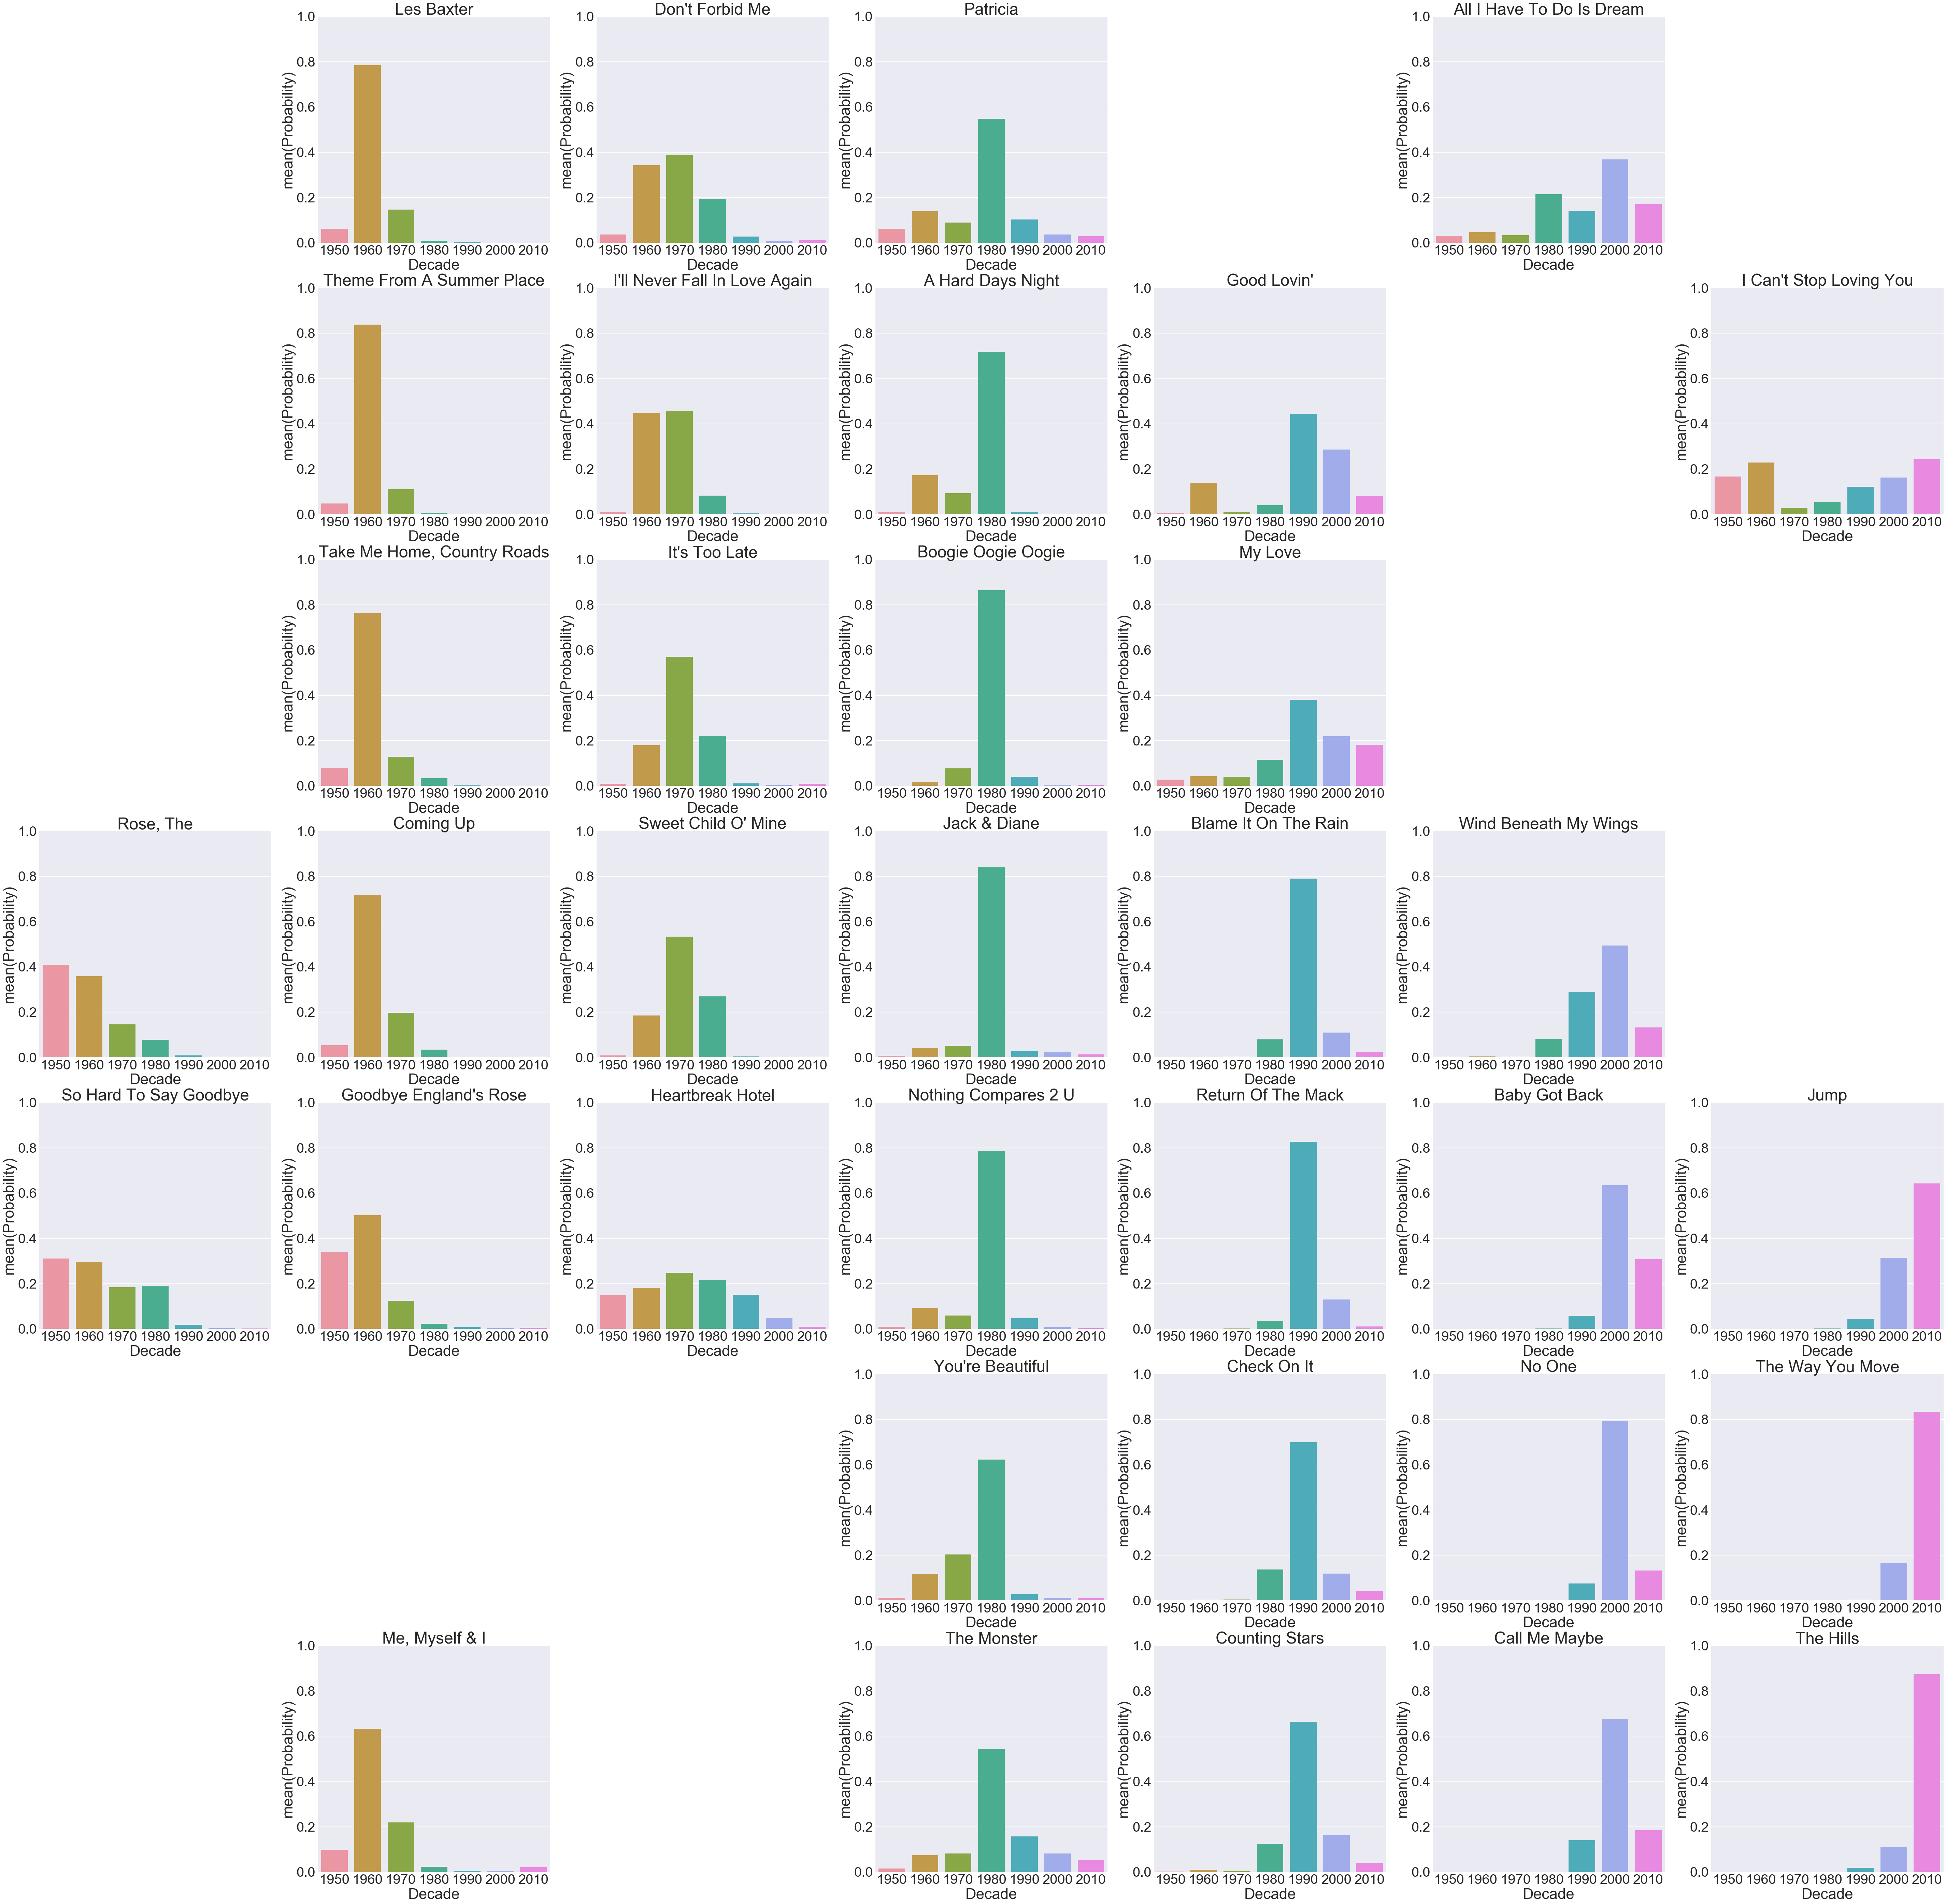

In [14]:
music_files_test = np.asarray(music_files_test)
decades = np.unique(Y_test_decade).tolist()
target_df_list = []

fig = plt.figure(figsize=(100, 100))
seaborn.set(font_scale=4)
for i, target in enumerate(decades):
    songnames = []
    artists = []
    probabilities = []
    
    for j,decade in enumerate(decades):
        songs_from_decade = music_files_test[Y_test_decade == decade]
        predictions_for_songs_from_decade = Y_predict_decade[Y_test_decade == decade]
        probabilities_for_songs_from_decade = (np.asarray(Y_predict_proba))[Y_test_decade == decade,:]
        
        songs_classified_as_target = songs_from_decade[np.argwhere(predictions_for_songs_from_decade == target)]
        probabilities_for_songs_classified_as_target = np.squeeze(probabilities_for_songs_from_decade[np.argwhere(predictions_for_songs_from_decade == target)],axis=1)[:,i]
        all_probabilities_for_songs_classified_as_target = np.squeeze(probabilities_for_songs_from_decade[np.argwhere(predictions_for_songs_from_decade == target)],axis=1)
        
        if songs_classified_as_target.tolist():
            highest_probability_index = np.argmax(probabilities_for_songs_classified_as_target)
            highest_probability = probabilities_for_songs_classified_as_target[highest_probability_index]
            most_probable_song = songs_classified_as_target[highest_probability_index]
            most_probable_song_probabilities = all_probabilities_for_songs_classified_as_target[highest_probability_index]
            
            songnames.append(os.path.basename(most_probable_song[0]).split('_')[1])
            artists.append(os.path.basename(most_probable_song[0]).split('_')[2].split('.')[0])
            probabilities.append(highest_probability)
            
            ax = fig.add_subplot(7,7,(j*7)+i+1)
            dictionary = {'Decade':np.asarray(decades), 'Probability':np.asarray(most_probable_song_probabilities)}
            df = pd.DataFrame()
            df = df.from_dict(dictionary)
            barplot = seaborn.barplot(x='Decade', y='Probability', data=df, ax=ax)
            axes = barplot.axes
            axes.set_ylim(0,1)
            axes.set_title((most_probable_song[0]).split('_')[1])
        else:
            songnames.append('')
            artists.append('')
            probabilities.append(0)

Now let's take a look at the classification probabilities for all of the songs from the 1990s and see which songs the model got correct and which songs the model was most confused by.  The heatmap below shows the full list of songs and is brightest when the probabilities were high for that decade.

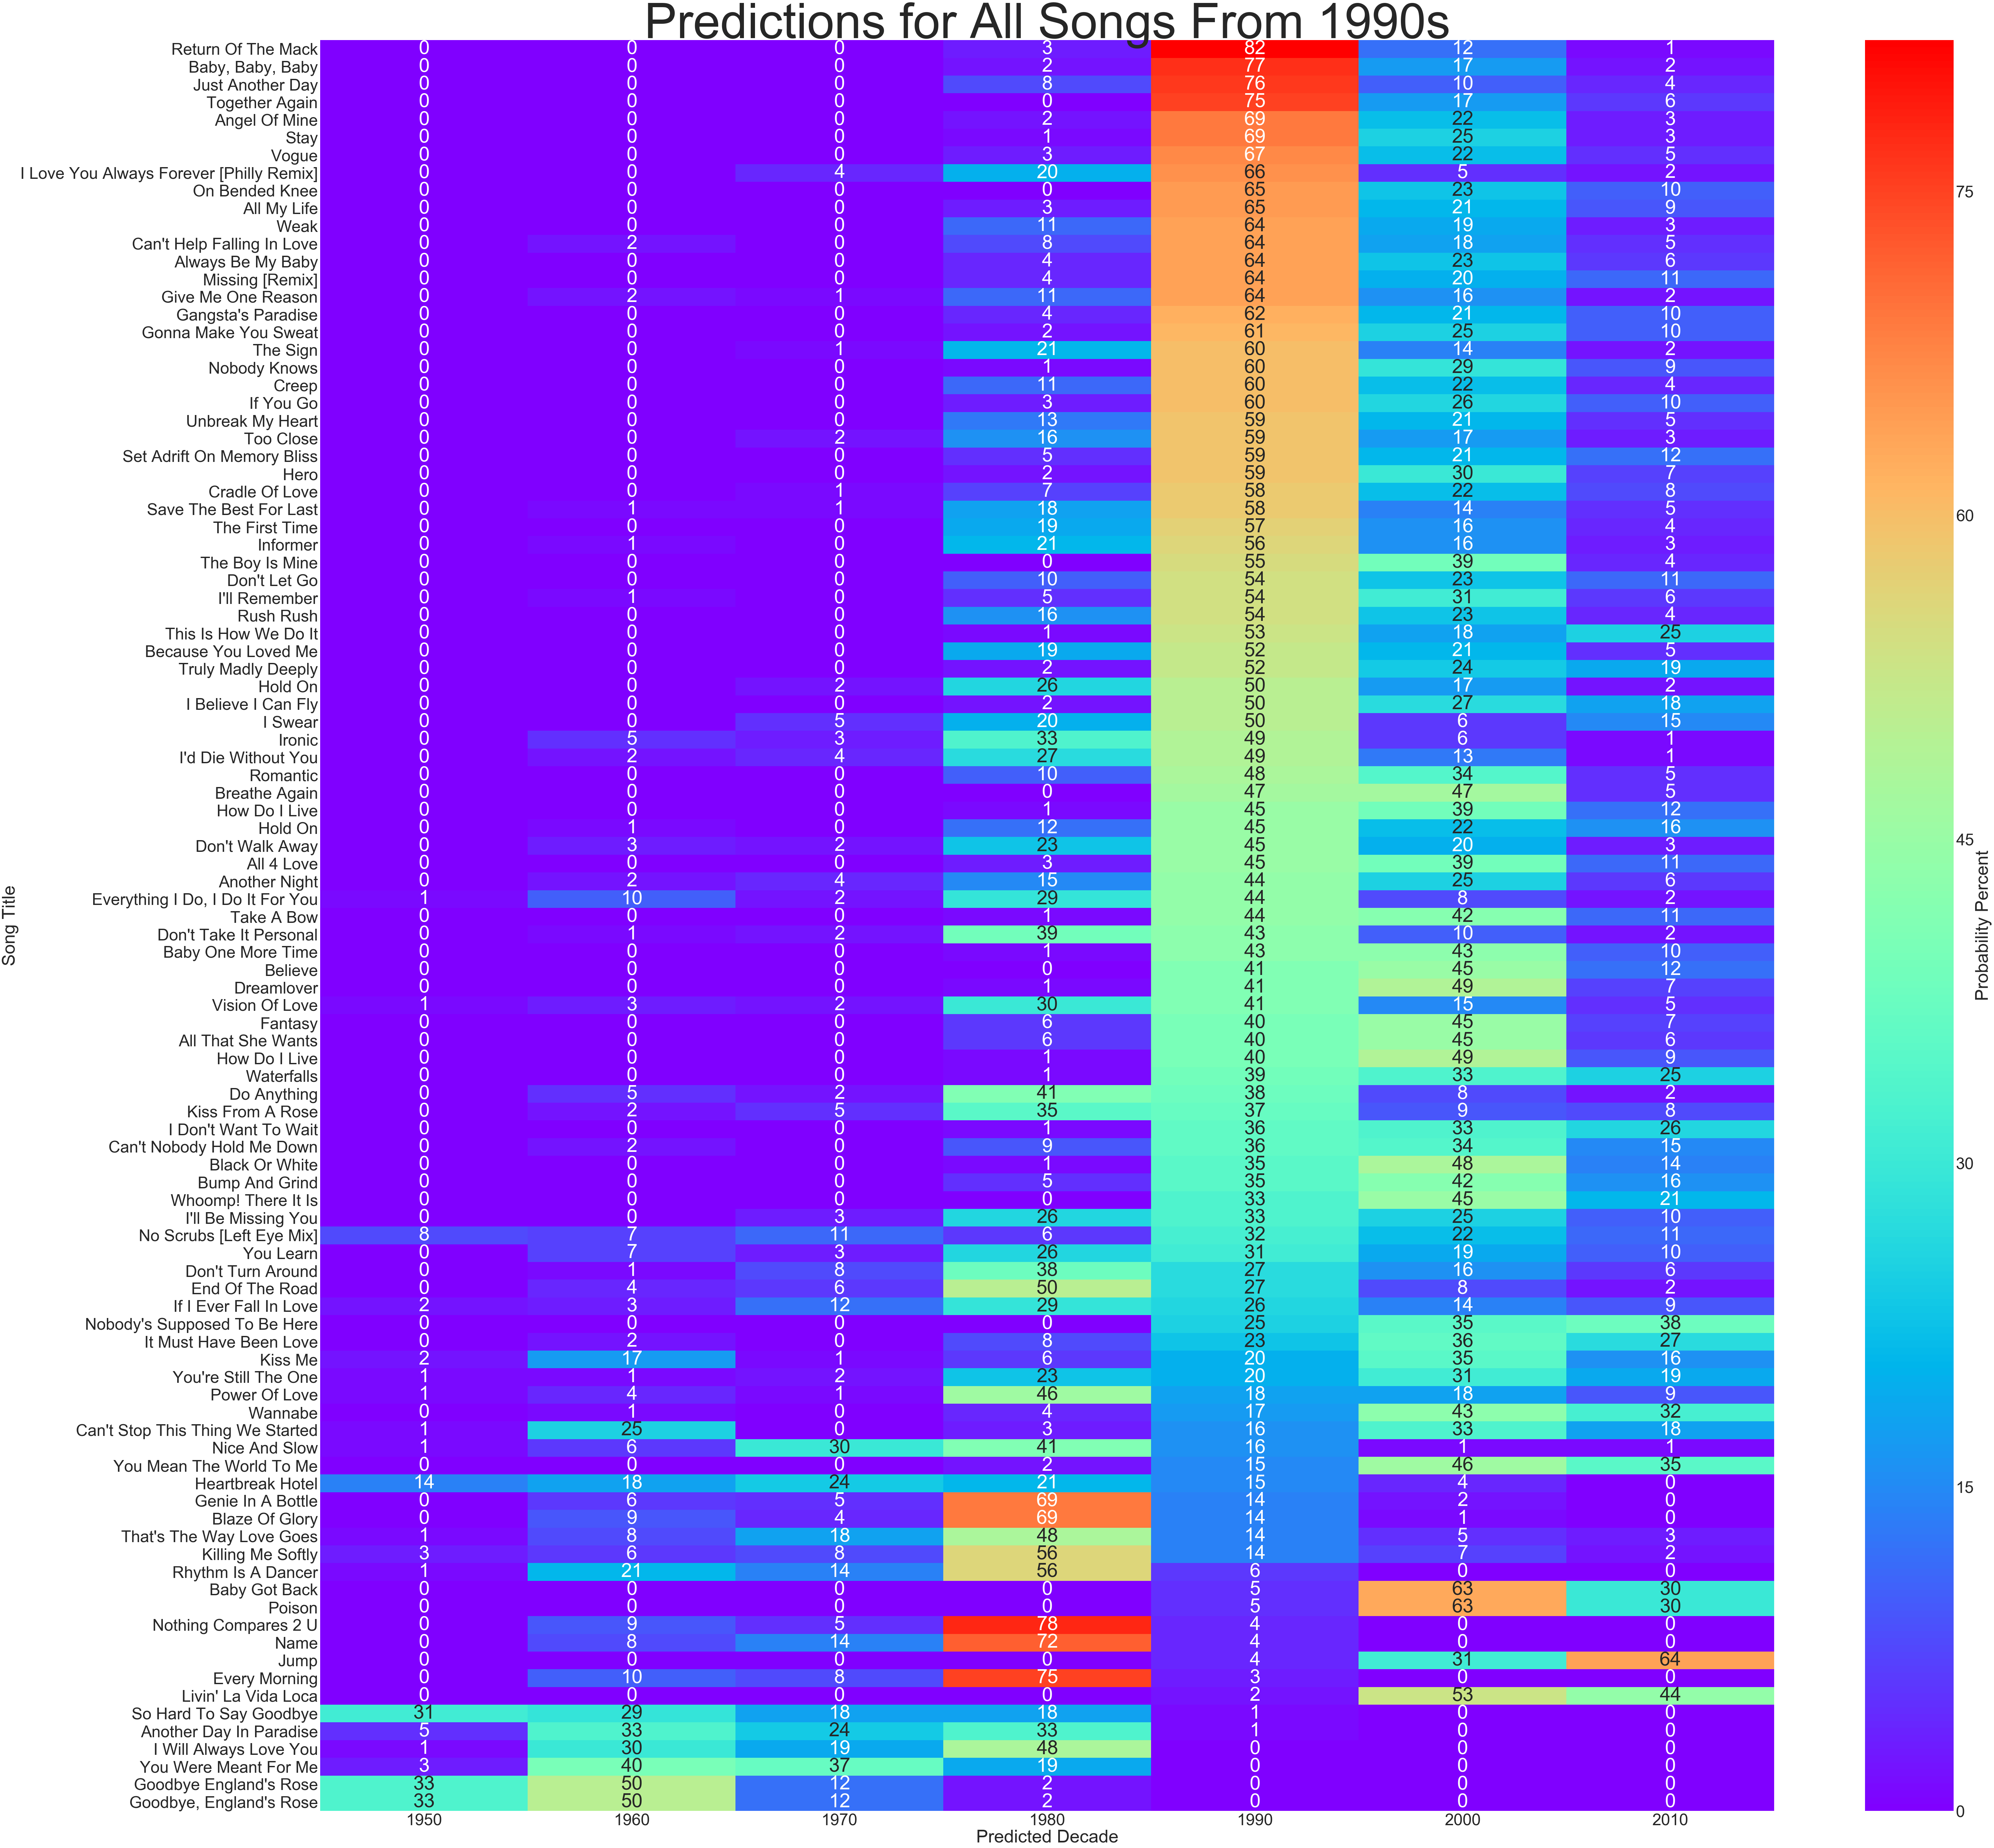

In [15]:
decade_index = 4
decade = decades[decade_index]
fig = plt.figure(figsize=(100, 100))
seaborn.set(font_scale=5)
songs_from_decade = music_files_test[Y_test_decade == decade]
songs_from_decade = [os.path.basename(song).split('_')[1] for song in songs_from_decade]
songs_from_decade = np.asarray(songs_from_decade)
probabilities_from_decade = (np.asarray(Y_predict_proba))[Y_test_decade == decade,:]
probabilities_from_decade = (probabilities_from_decade*100).astype(int)
sorting_probability = probabilities_from_decade[:,decade_index]
sorted_indices = np.argsort(-sorting_probability)
songs_sorted = songs_from_decade[sorted_indices]
probabilities_sorted = probabilities_from_decade[sorted_indices]

df_decade = pd.DataFrame(probabilities_sorted, index=songs_sorted, columns=decades)
heatmap_decade = seaborn.heatmap(df_decade,cmap=cm.rainbow,cbar_kws={'label': 'Probability Percent'}, annot=True, fmt="d")

heatmap_decade.set(xlabel='Predicted Decade', ylabel='Song Title')
heatmap_decade.set_title('Predictions for All Songs From '+str(decade)+'s', fontsize = 150)
heatmap_decade_fig = heatmap_decade.get_figure()
heatmap_decade_fig.savefig('Plot2_'+str(decade)+'s_Predictions.png')
plt.show()

Now, let's determine which songs the model was most confused about and which songs the model was most sure about.  I determine this by using the standard deviations of the probability arrays.  The arrays with smallest standard deviations are the ones where the probabilities for each class were more equal.  From the music clips, we can see that some misclassifications happen due to the short length of the clip.  For example, the clip of "Royals" by Lorde contains background harmonies that are similar to those of girl groups from the 1960s, so it is understandable that it would be misclassified as the 1960s.

You Can't Hurry Love
Diana Ross & The Supremes
1966


Royals
Lorde
2013


I Can't Stop Loving You
Ray Charles
1962


We Found Love
Rihanna Ft Calvin Harris
2012


Boogie Oogie Oogie
A Taste Of Honey
1978


The Hills
The Weeknd
2015


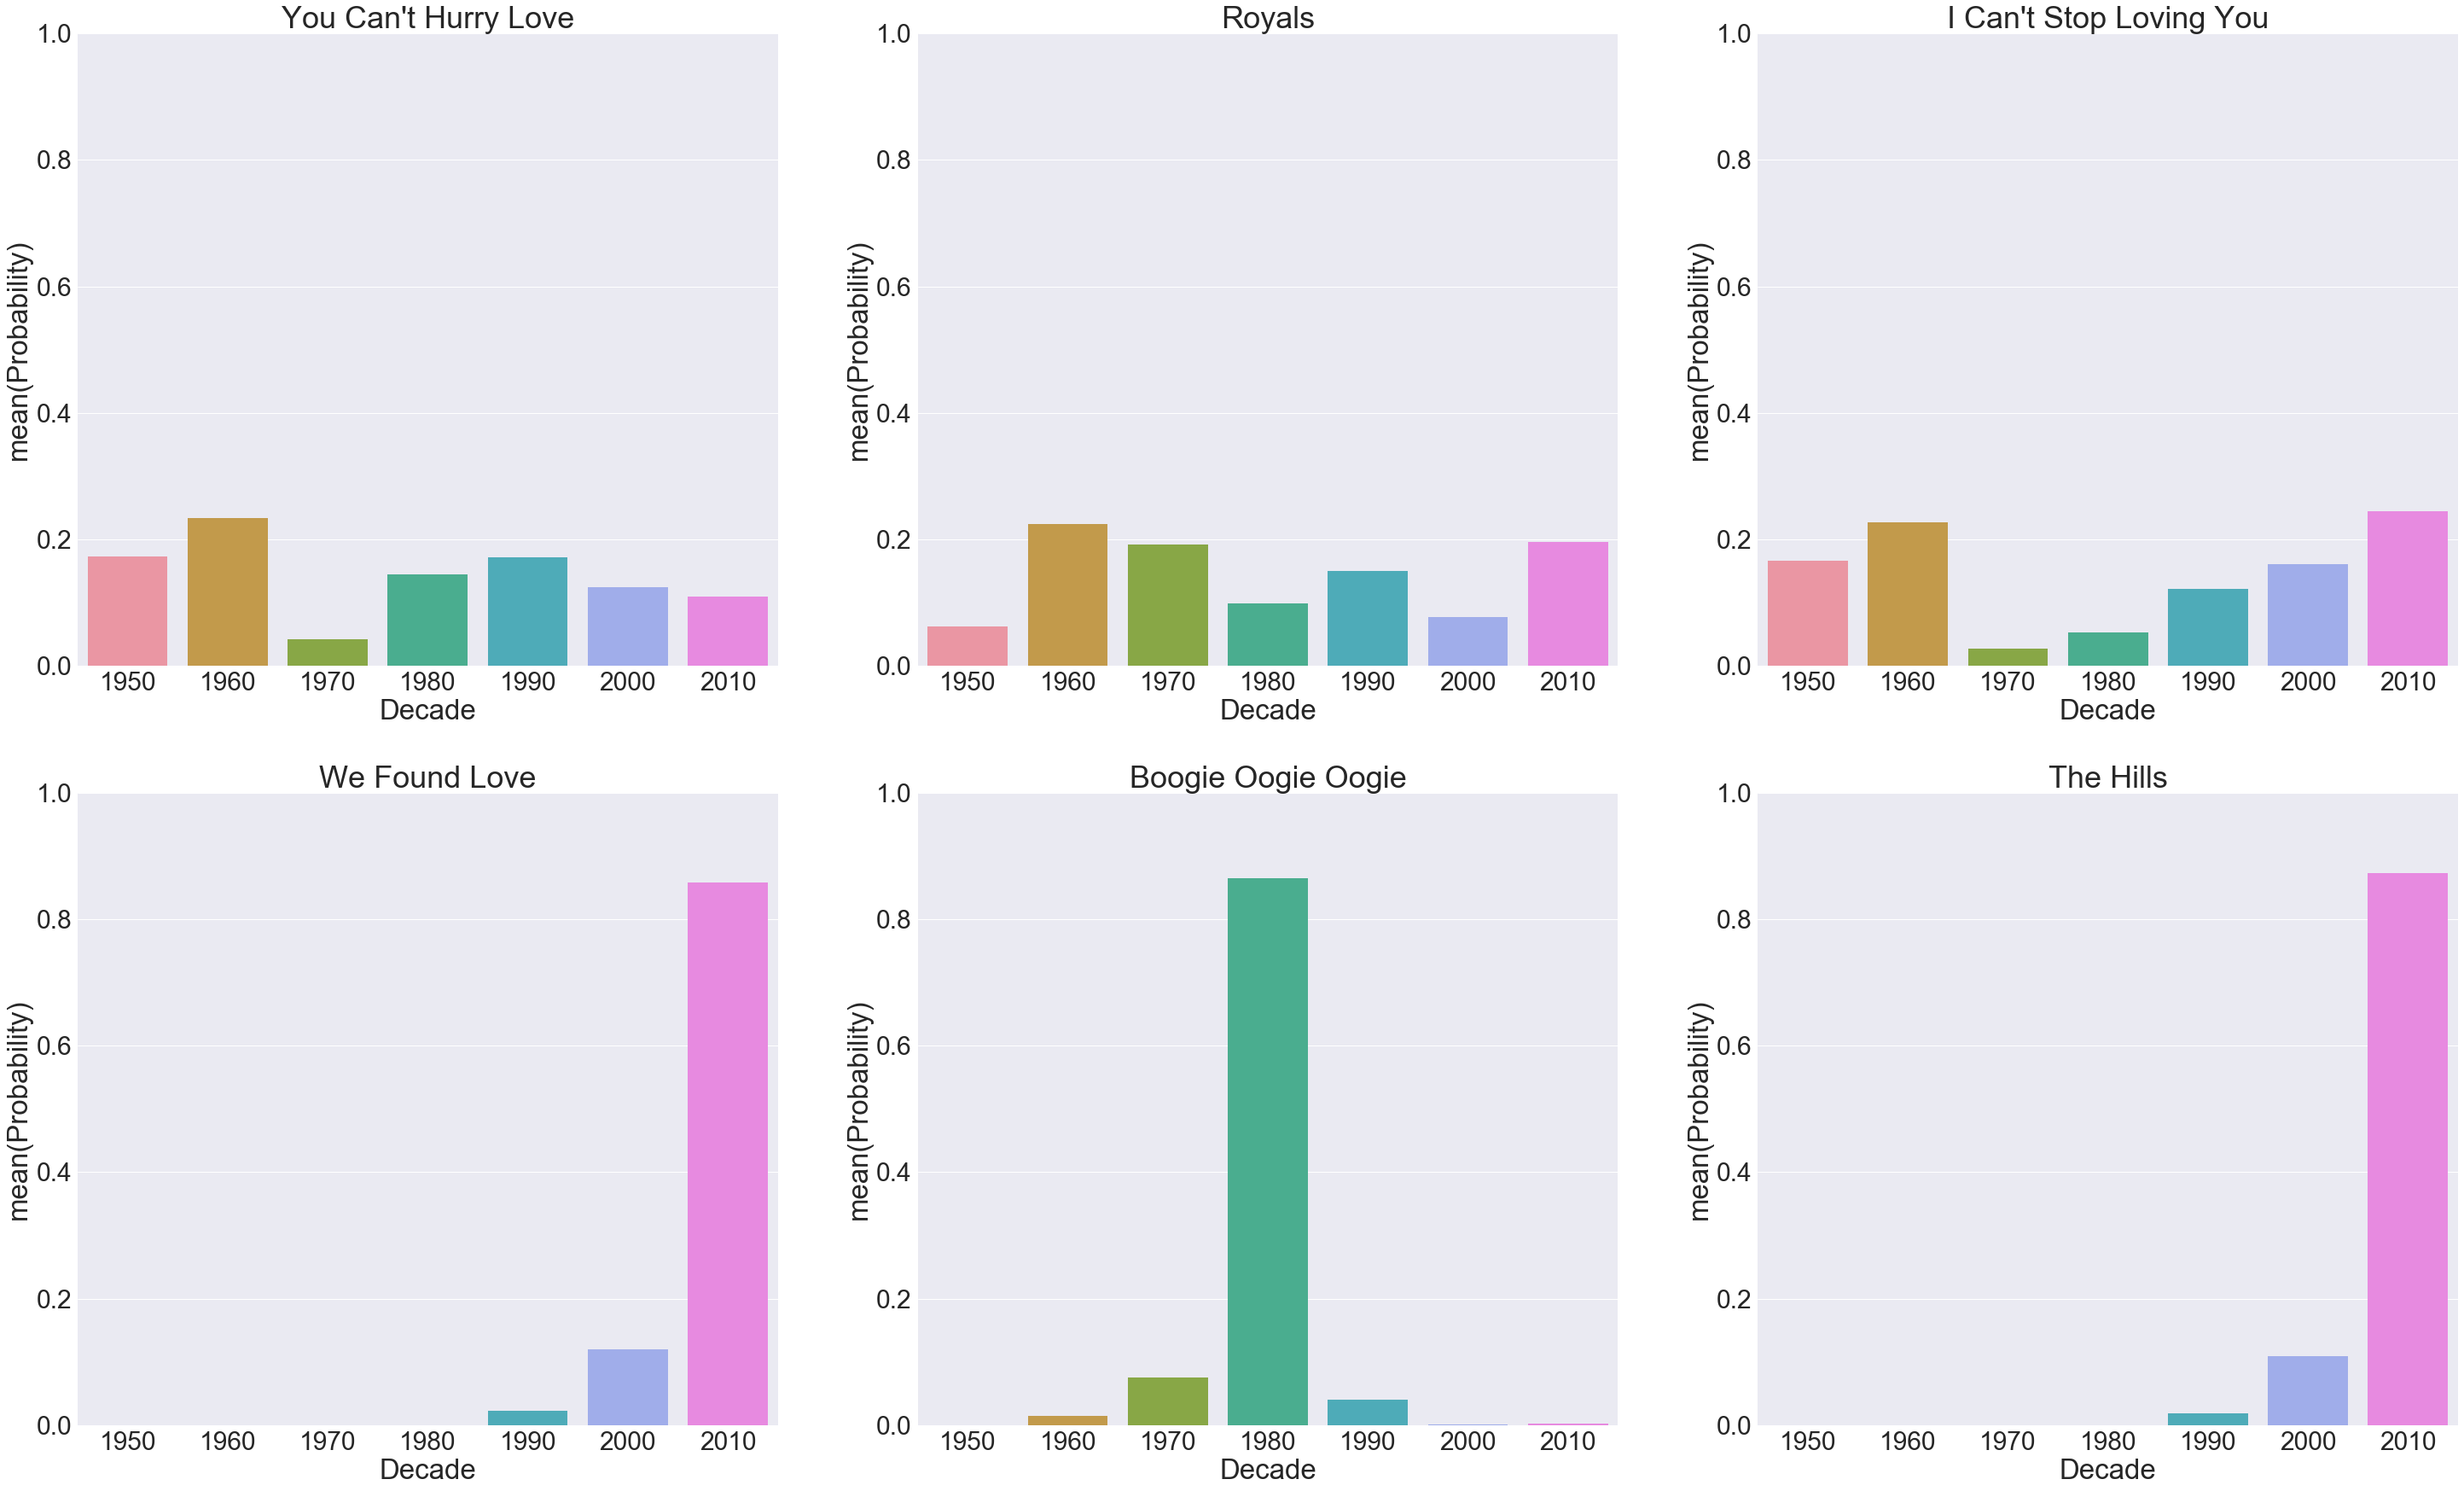

In [17]:
stdev = np.std(Y_predict_proba,axis=1)
sorted_indices = np.argsort(stdev)
songs_sorted_stdev = music_files_test[sorted_indices]
probabilities_sorted_stdev = Y_predict_proba[sorted_indices,:]
years_sorted = Y_test_decade[sorted_indices]
years_sorted

least_sure_songs = songs_sorted_stdev[:3].tolist()
least_sure_probabilities = probabilities_sorted_stdev[:3,:]
most_sure_songs = songs_sorted_stdev[-3:].tolist()
most_sure_probabilities = probabilities_sorted_stdev[-3:,:]

fig = plt.figure(figsize=(50, 30))
seaborn.set(font_scale=3)
for i,song in enumerate(least_sure_songs):
    print(os.path.basename(song).split('_')[1])
    print(os.path.basename(song).split('_')[2].split('.')[0])
    print(os.path.basename(os.path.dirname(song)))
    audio_time_series, sampling_rate = librosa.load(song)
    length = len(audio_time_series)
    middle_index = int(length/2)
    song_middle = audio_time_series[middle_index-50000:middle_index+50000]
    ipd.display(ipd.Audio(song_middle, rate=sampling_rate))
    probability_list = least_sure_probabilities[i,:]
    dictionary = {'Decade':np.asarray(decades), 'Probability':np.asarray(probability_list)}
    df = pd.DataFrame()
    df = df.from_dict(dictionary)
    ax = fig.add_subplot(2,3,i+1)
    barplot = seaborn.barplot(x='Decade', y='Probability', data=df, ax=ax)
    axes = barplot.axes
    axes.set_ylim(0,1)
    axes.set_title(os.path.basename(song).split('_')[1])
    
for i,song in enumerate(most_sure_songs):
    print(os.path.basename(song).split('_')[1])
    print(os.path.basename(song).split('_')[2].split('.')[0])
    print(os.path.basename(os.path.dirname(song)))
    audio_time_series, sampling_rate = librosa.load(song)
    length = len(audio_time_series)
    middle_index = int(length/2)
    song_middle = audio_time_series[middle_index-50000:middle_index+50000]
    ipd.display(ipd.Audio(song_middle, rate=sampling_rate))
    probability_list = most_sure_probabilities[i,:]
    dictionary = {'Decade':np.asarray(decades), 'Probability':np.asarray(probability_list)}
    df = pd.DataFrame()
    df = df.from_dict(dictionary)
    ax = fig.add_subplot(2,3,i+4)
    barplot = seaborn.barplot(x='Decade', y='Probability', data=df)
    axes = barplot.axes
    axes.set_ylim(0,1)
    axes.set_title(os.path.basename(song).split('_')[1])
    
plt.show()